# **Imports**

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from sklearn.cluster import KMeans
import logging
import warnings

# **Loading Data and Data Cleaning**

In [3]:
# Read and preprocess data
main_df = pd.read_excel("DSA210_data.xlsx")

# Convert date column to datetime and create new 'PERIOD' column
main_df["DATE"] = pd.to_datetime(main_df["DATE"], format="%Y-%m")
main_df["PERIOD"] = main_df["DATE"].dt.to_period("Q").apply(lambda x: f"{x.year}-Q{x.quarter}")

# Convert 'Oil prices' column to numeric value
main_df["Oil prices"] = main_df["Oil prices"].str.replace(" TL", "").str.replace(",", ".").astype(float)

# Simplify column names
main_df = main_df.rename(columns={
    "(USD) US DOLLAR EFFECTIVE SALE": "usd",
    "TÜFE (GENERAL)": "CIP_general",
    "TÜFE (FOOD AND BEVERAGES )": "CIP_food"
})

# Uploading Unemployment Data
unemp_df = pd.read_excel("DSA210_unemployment_rate_data.xlsx")
unemp_df["YEAR"] = unemp_df["YEAR"].ffill().astype(int)
unemp_df["PERIOD"] = unemp_df["YEAR"].astype(str) + "-Q" + unemp_df["QUARTER"].astype(str)

#Merging Datasets
merged_df = pd.merge(main_df, unemp_df[["PERIOD", "UNEMPLOYMENT RATE"]], on="PERIOD", how="left")

#Standardization
scaler = StandardScaler()
features_to_scale = ["usd", "CIP_general", "CIP_food", "Oil prices", "UNEMPLOYMENT RATE"]
scaled = scaler.fit_transform(merged_df[features_to_scale])
scaled_df = pd.DataFrame(scaled, columns=[col + "_std" for col in features_to_scale], index=merged_df.index)

# Son haline ekle
merged_df = pd.concat([merged_df, scaled_df], axis=1)

# **Data Visualization**

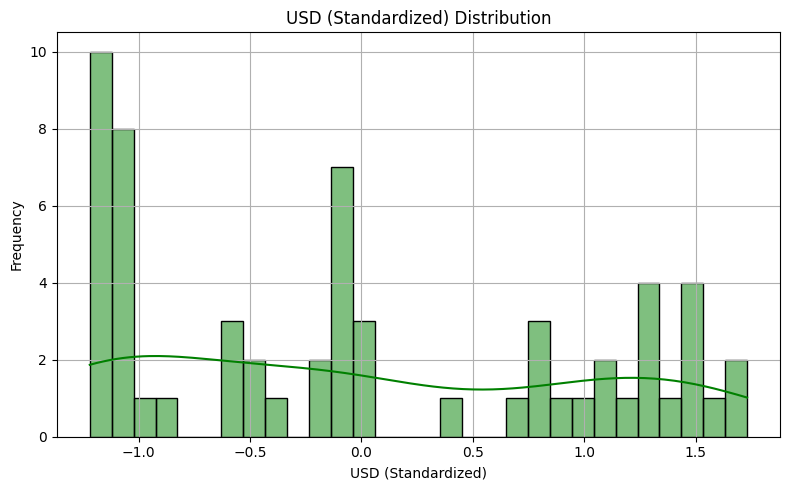

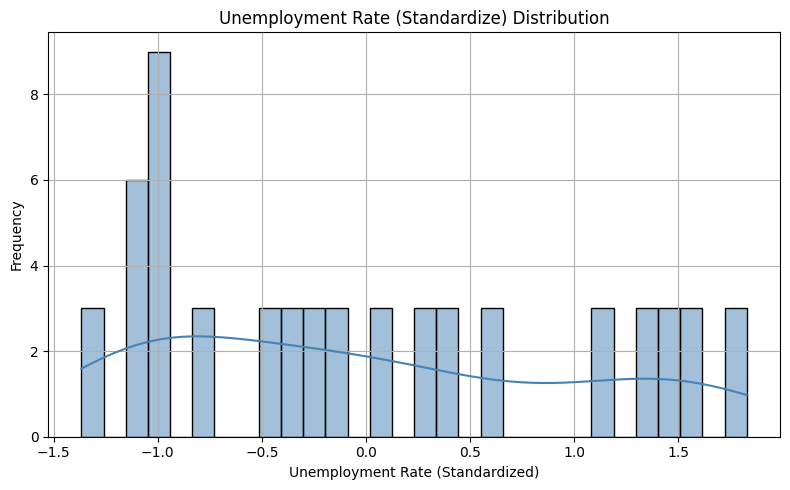

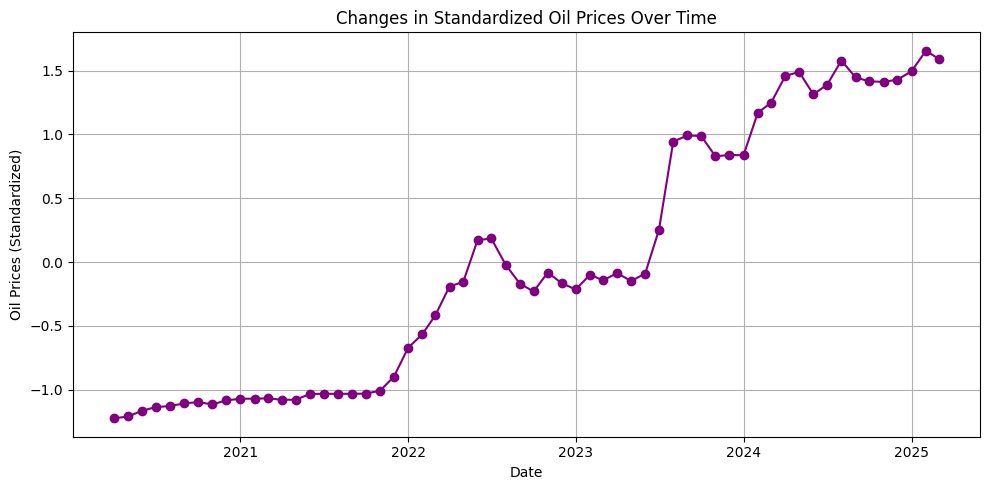

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['usd_std'], kde=True, bins=30, color='green', edgecolor='black')
plt.title("USD (Standardized) Distribution")
plt.xlabel("USD (Standardized)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(merged_df["UNEMPLOYMENT RATE_std"], kde=True, bins=30, color='steelblue', edgecolor='black')
plt.title("Unemployment Rate (Standardize) Distribution")
plt.xlabel("Unemployment Rate (Standardized)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(merged_df["DATE"], merged_df["Oil prices_std"], marker='o', linestyle='-', color='purple')
plt.title("Changes in Standardized Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Oil Prices (Standardized)")
plt.grid(True)
plt.tight_layout()
plt.show()

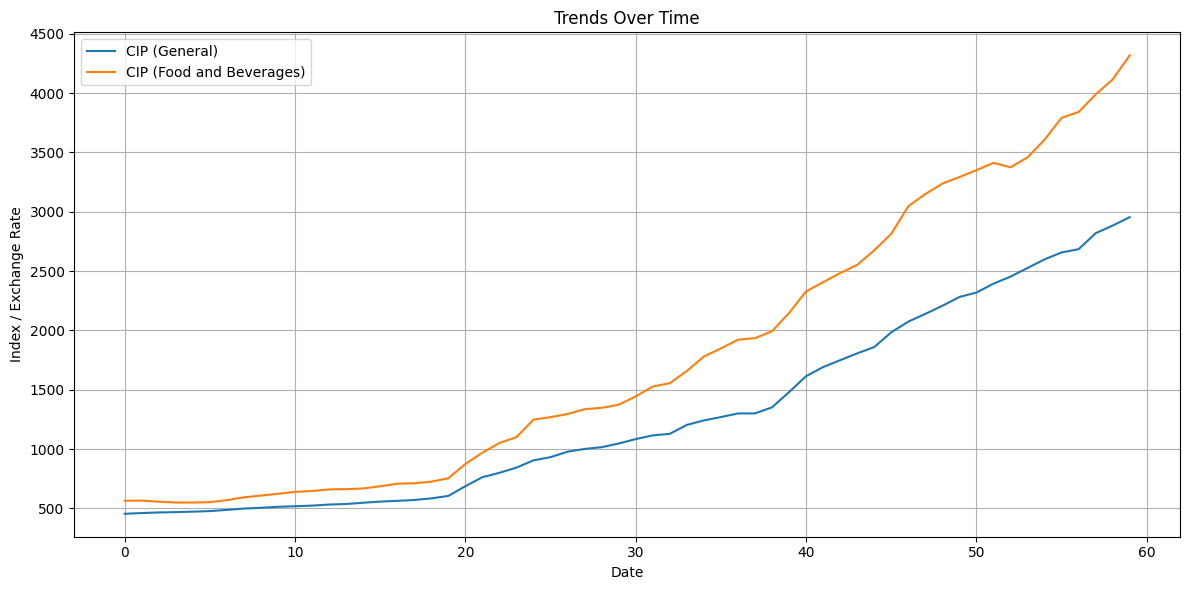

In [5]:
# Plot trends
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['CIP_general'], label='CIP (General)') # Changed df to merged_df
plt.plot(merged_df.index, merged_df['CIP_food'], label='CIP (Food and Beverages)') # Changed df to merged_df
plt.title('Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Index / Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

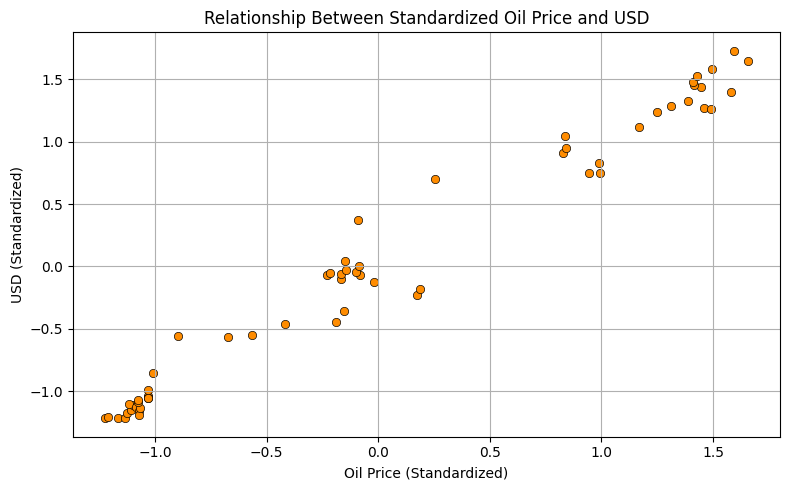

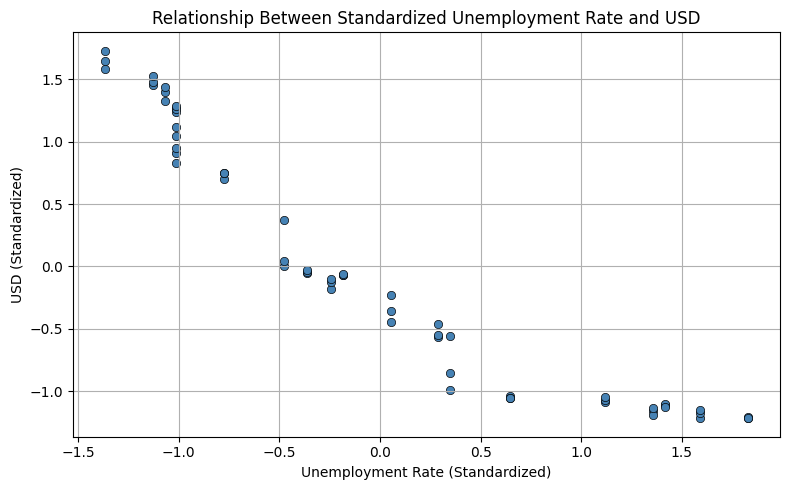

In [6]:
# --- Oil Price vs USD ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_df, x="Oil prices_std", y="usd_std", color='darkorange', edgecolor='black')
plt.title("Relationship Between Standardized Oil Price and USD")
plt.xlabel("Oil Price (Standardized)")
plt.ylabel("USD (Standardized)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Unemployment Rate vs USD ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged_df, x="UNEMPLOYMENT RATE_std", y="usd_std", color='steelblue', edgecolor='black')
plt.title("Relationship Between Standardized Unemployment Rate and USD")
plt.xlabel("Unemployment Rate (Standardized)")
plt.ylabel("USD (Standardized)")
plt.grid(True)
plt.tight_layout()
plt.show()

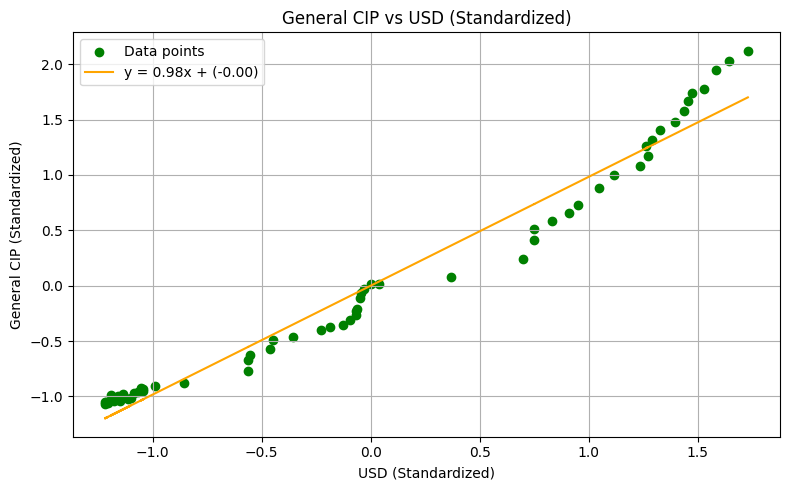

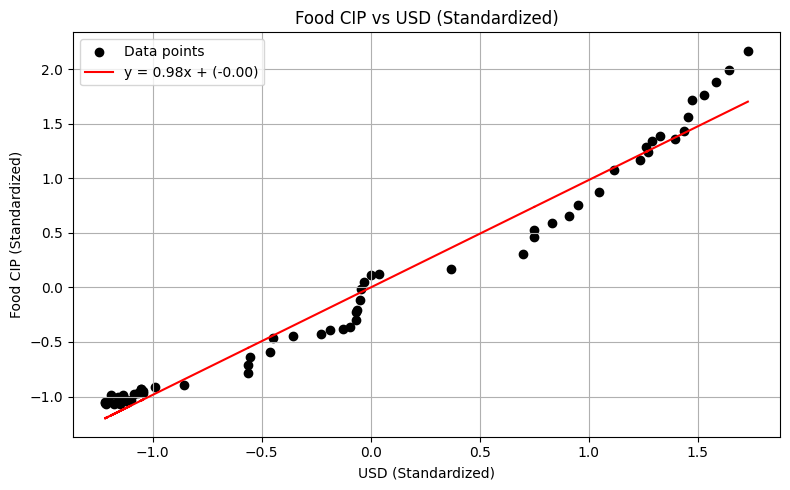

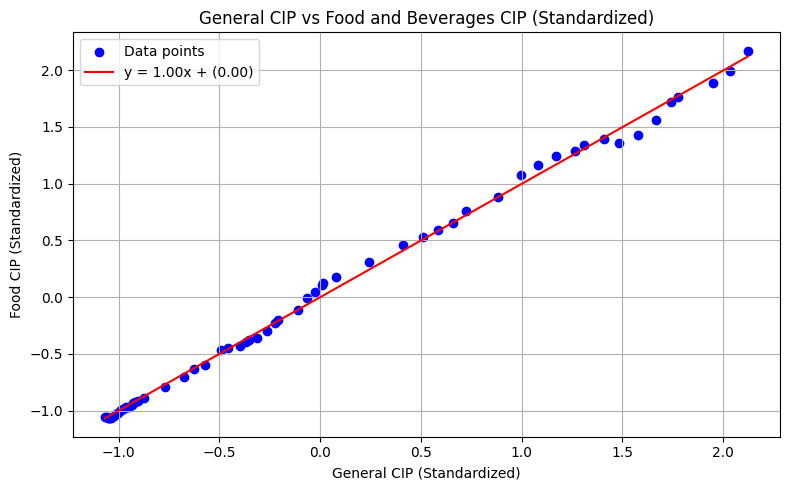

In [7]:
#Scatter plot
def scatter_with_regression(x, y, x_label, y_label, title, color_points, color_line):
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, color=color_points, label="Data points")
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, color=color_line, label=f"y = {m:.2f}x + ({b:.2f})")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Corrected calls using merged_df
scatter_with_regression(merged_df["usd_std"], merged_df["CIP_general_std"],
                        "USD (Standardized)", "General CIP (Standardized)",
                        "General CIP vs USD (Standardized)",
                        color_points="green", color_line="orange")

scatter_with_regression(merged_df["usd_std"], merged_df["CIP_food_std"],
                        "USD (Standardized)", "Food CIP (Standardized)",
                        "Food CIP vs USD (Standardized)",
                        color_points="black", color_line="red")

scatter_with_regression(merged_df["CIP_general_std"], merged_df["CIP_food_std"],
                        "General CIP (Standardized)", "Food CIP (Standardized)",
                        "General CIP vs Food and Beverages CIP (Standardized)",
                        color_points="blue", color_line="red")

# **Regression and Correlation Analysis**

In [8]:
# Correlation analysis for USD and independent variables
variables = {
    "Oil Prices": "Oil prices_std",
    "Unemployment Rate": "UNEMPLOYMENT RATE_std"
}


for label, col in variables.items():
    corr, pval = pearsonr(merged_df["usd_std"], merged_df[col])
    print(f"{label} vs USD - Correlation: {corr:.3f}")
    print(f"P-Value: {pval:.3e}")
    if pval < 0.05:
        print("Significant relationship.\n")
    else:
        print("Not significant.\n")

Oil Prices vs USD - Correlation: 0.987
P-Value: 3.182e-48
Significant relationship.

Unemployment Rate vs USD - Correlation: -0.946
P-Value: 4.917e-30
Significant relationship.



Food CIP vs USD - Correlation: 0.98480917136017
P-Value: 8.403957146333189e-46
Significant relationship.

General CIP vs USD - Correlation: 0.9828703882008646
P-Value: 2.6657376154698394e-44
Significant relationship.



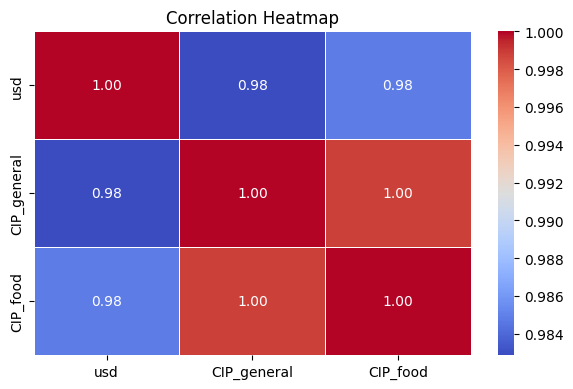

In [32]:
# Regression and Correlation
# Changed df to merged_df
X_food = sm.add_constant(merged_df["usd_std"])
y_food = merged_df["CIP_food_std"]
model_food = sm.OLS(y_food, X_food).fit()
# Changed df to merged_df
correlation_food, p_value_usd_food = pearsonr(merged_df["usd_std"], merged_df["CIP_food_std"])
print("Food CIP vs USD - Correlation:", correlation_food)
print("P-Value:", p_value_usd_food)
print("Significant relationship." if p_value_usd_food < 0.05 else "No significant relationship.")
print()

# Changed df to merged_df
X_general = sm.add_constant(merged_df["usd_std"])
y_general = merged_df["CIP_general_std"]
model_general = sm.OLS(y_general, X_general).fit()
# Changed df to merged_df
correlation_general, p_value_usd_general = pearsonr(merged_df["usd_std"], merged_df["CIP_general_std"])
print("General CIP vs USD - Correlation:", correlation_general)
print("P-Value:", p_value_usd_general)
print("Significant relationship." if p_value_usd_general < 0.05 else "No significant relationship.")
print()

# Compute correlation matrix
# Changed df to merged_df
corr_matrix = merged_df[['usd', 'CIP_general', 'CIP_food']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [33]:
merged_df["Oil_price_lag1"] = merged_df["Oil prices"].shift(1)
merged_df["Unemployment_lag1"] = merged_df["UNEMPLOYMENT RATE"].shift(1)

import statsmodels.api as sm

# Independent variables: unemployment and oil last quarter
X = merged_df[["Oil_price_lag1", "Unemployment_lag1"]].dropna()
X = sm.add_constant(X)

# Dependent variable: food prices in the current quarter
y = merged_df["CIP_food"].iloc[1:]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               CIP_food   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     509.3
Date:                Fri, 30 May 2025   Prob (F-statistic):           1.19e-36
Time:                        19:41:50   Log-Likelihood:                -413.01
No. Observations:                  59   AIC:                             832.0
Df Residuals:                      56   BIC:                             838.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               616.3703    723.99

# **Hypothesis Testing**


In [34]:
if p_value_usd_food < 0.05 and p_value_usd_general < 0.05:
    print("Final Conclusion: We fail to reject the null hypothesis (H₀).")
    print("Exchange rates have a statistically significant effect on grocery prices in Turkey.")
else:
    print("Final Conclusion: We reject the null hypothesis (H₀).")
    print("Exchange rates do not have a statistically significant effect on grocery prices.")

Final Conclusion: We fail to reject the null hypothesis (H₀).
Exchange rates have a statistically significant effect on grocery prices in Turkey.


# **Machine Learning Methods**


**Prophet Modelling**

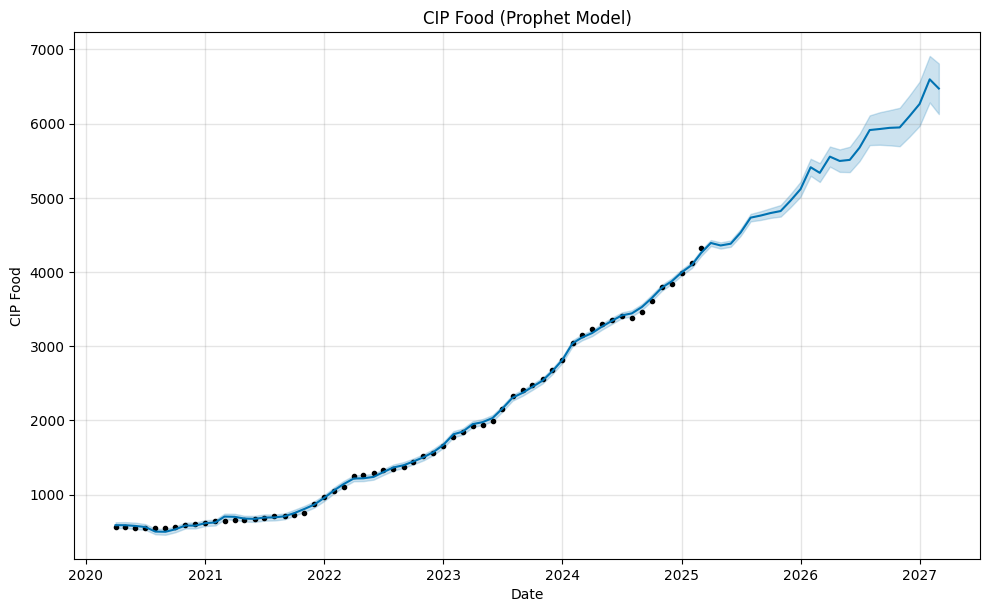

In [37]:
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
warnings.filterwarnings('ignore', message="'M' is deprecated")

# Preparing Data
prophet_df = merged_df.rename(columns={
    "DATE": "ds",
    "CIP_food": "y"
})

# Fit and Forecast
model = Prophet()
model.fit(prophet_df[['ds', 'y']])

future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

# Plot
fig1 = model.plot(forecast)
plt.title("CIP Food (Prophet Model)")
plt.xlabel("Date")
plt.ylabel("CIP Food")
plt.show()


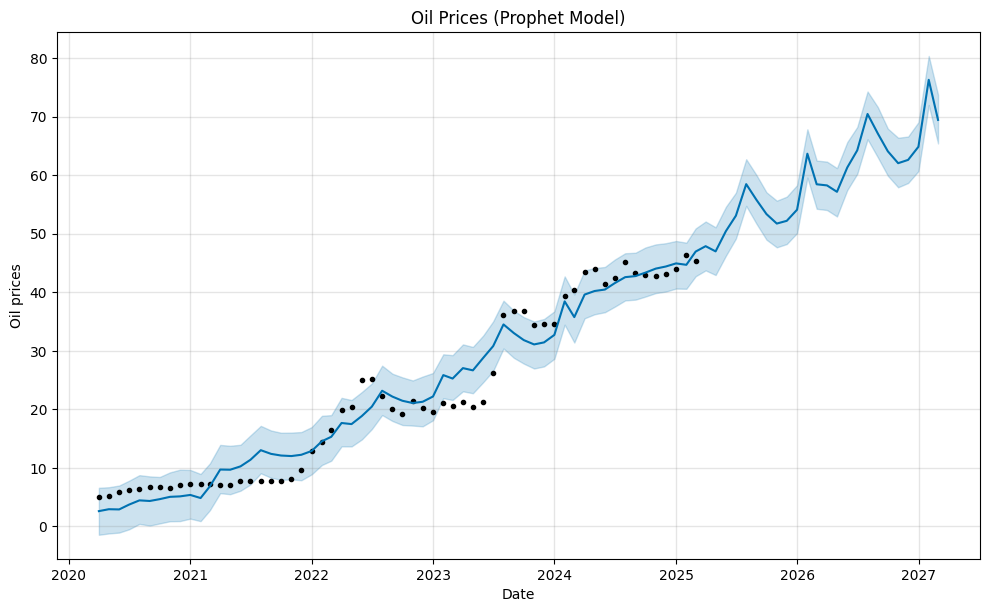

In [38]:
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
warnings.filterwarnings('ignore', message="'M' is deprecated")

# Preparing Data
prophet_df = merged_df.rename(columns={
    "DATE": "ds",
    "Oil prices": "y"
})

# Fit and Forecast
model = Prophet()
model.fit(prophet_df[['ds', 'y']])

future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

# Plot
fig1 = model.plot(forecast)
plt.title("Oil Prices (Prophet Model)")
plt.xlabel("Date")
plt.ylabel("Oil prices")
plt.show()


**KMeans Modelling**


        DATE       usd  CIP_general  CIP_food  cluster
0 2020-04-01  6.841490       454.43    564.32        2
1 2020-05-01  6.974929       460.62    565.68        2
2 2020-06-01  6.831323       465.84    556.61        2
3 2020-07-01  6.873757       468.56    549.48        2
4 2020-08-01  7.276150       472.61    549.04        2


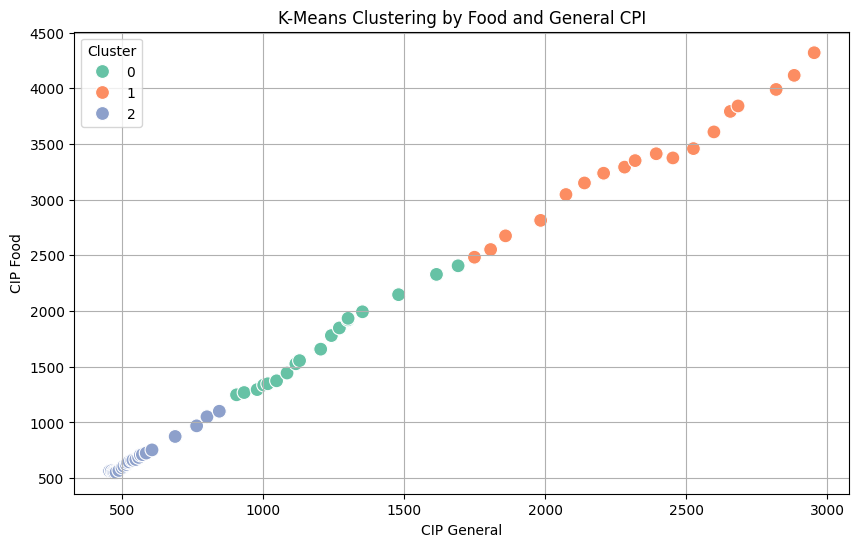

In [39]:
features = merged_df[["usd", "CIP_general", "CIP_food"]]
scaler = StandardScaler()
scaled = scaler.fit_transform(features)


kmeans = KMeans(n_clusters=3, random_state=42)
merged_df["cluster"] = kmeans.fit_predict(scaled)


print(merged_df[["DATE", "usd", "CIP_general", "CIP_food", "cluster"]].head())

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="CIP_general", y="CIP_food", hue="cluster", palette="Set2", s=100)
plt.title("K-Means Clustering by Food and General CPI")
plt.xlabel("CIP General")
plt.ylabel("CIP Food")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

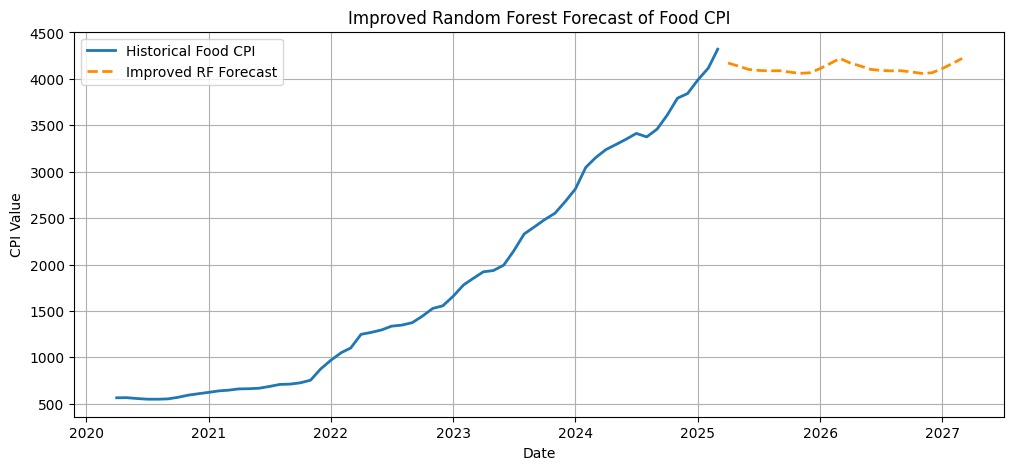

In [40]:
# Data
df = pd.read_excel("DSA210_data.xlsx")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.rename(columns={
    "(USD) US DOLLAR EFFECTIVE SALE": "usd",
    "TÜFE (GENERAL)": "CIP_general",
    "TÜFE (FOOD AND BEVERAGES )": "CIP_food"
})
df.set_index("DATE", inplace=True)

df["month"] = df.index.month
df["year"] = df.index.year
df["time_index"] = np.arange(len(df))
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Model inputs
X = df[["usd", "time_index", "month_sin", "month_cos"]]
y = df["CIP_food"]

# Train the model
model = RandomForestRegressor(n_estimators=150, random_state=42)
model.fit(X, y)

# New data for the next 24 months
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='MS')
future_df = pd.DataFrame(index=future_dates)
future_df["month"] = future_df.index.month
future_df["year"] = future_df.index.year
future_df["time_index"] = np.arange(len(df), len(df) + len(future_df))
future_df["month_sin"] = np.sin(2 * np.pi * future_df["month"] / 12)
future_df["month_cos"] = np.cos(2 * np.pi * future_df["month"] / 12)

# USD scenario: exchange rate increasing by 0.75% every month
usd_start = df["usd"].iloc[-1]
future_df["usd"] = [usd_start * (1.0075 ** i) for i in range(24)]

# Prediction
future_pred = model.predict(future_df[["usd", "time_index", "month_sin", "month_cos"]])

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["CIP_food"], label="Historical Food CPI", linewidth=2)
plt.plot(future_df.index, future_pred, label="Improved RF Forecast", linestyle="--", color="darkorange", linewidth=2)
plt.title("Improved Random Forest Forecast of Food CPI")
plt.xlabel("Date")
plt.ylabel("CPI Value")
plt.legend()
plt.grid(True)
plt.show()
